In [1]:
import pandas as pd
import numpy as np

import utils

import matplotlib.pyplot as plt

In [2]:
SEC_TO_H = 3600
B_TO_KB = 1000

In [3]:
def is_flag(flag):
    def is_node_type(row):
        return flag in row['flags']
    return is_node_type

In [4]:
df = pd.read_csv('../tmp/top_100_nodes_20211206_to_20211212.csv')
kwargs = {
    'types': {
        'nickname': 'string',
        'ip': 'string',
        'consensus_time': 'datetime64[s]',
        'pub_time': 'datetime64[s]',
        'or_port': 'UInt16',
        'dir_port': 'UInt16',
        'bandwidth': 'UInt32'
    },
    'transforms': {
        'flags': utils.parse_flags
    },
    'sort': ['consensus_time']
}
df = utils.prepare(df, **kwargs)
df['bandwidth'] = df['bandwidth'].apply(lambda x: x / B_TO_KB)
df['hours_since_pub'] = df.apply(lambda row: (row['consensus_time'] - row['pub_time']).total_seconds() // SEC_TO_H, axis=1)
df['is_guard'] = df.apply(is_flag('Guard'), axis=1)
df['is_exit'] = df.apply(is_flag('Exit'), axis=1)
df['is_fast'] = df.apply(is_flag('Fast'), axis=1)
df['is_both'] = df.apply(lambda row: row['is_guard'] and row['is_exit'], axis=1)

In [5]:
display_columns = [
    'ip', 'consensus_time', 'pub_time',
    'hours_since_pub', 'bandwidth', 'is_guard',
    'is_exit', 'is_fast', 'is_both'
]
df.loc[:, display_columns].head()

,ip,consensus_time,pub_time,hours_since_pub,bandwidth,is_guard,is_exit,is_fast,is_both
16098,82.165.169.47,2021-12-06,2021-12-05 08:14:42,15.0,77.0,True,False,True,False
16028,176.9.98.108,2021-12-06,2021-12-05 18:35:55,5.0,110.0,True,False,True,False
16029,162.55.131.67,2021-12-06,2021-12-05 10:05:26,13.0,101.0,True,False,True,False
16030,62.210.97.21,2021-12-06,2021-12-05 09:16:16,14.0,100.0,True,False,True,False
16031,87.236.195.253,2021-12-06,2021-12-05 14:54:28,9.0,100.0,True,False,True,False


In [6]:
num_vars = ['bandwidth', 'hours_since_pub']
df.loc[:, num_vars].describe()

,bandwidth,hours_since_pub
count,16800.000000,16800.000000
mean,100.072613,9.419226
std,24.661323,5.225280
min,74.000000,1.000000
25%,82.000000,5.000000
50%,92.000000,9.000000
75%,110.000000,14.000000
max,200.000000,24.000000


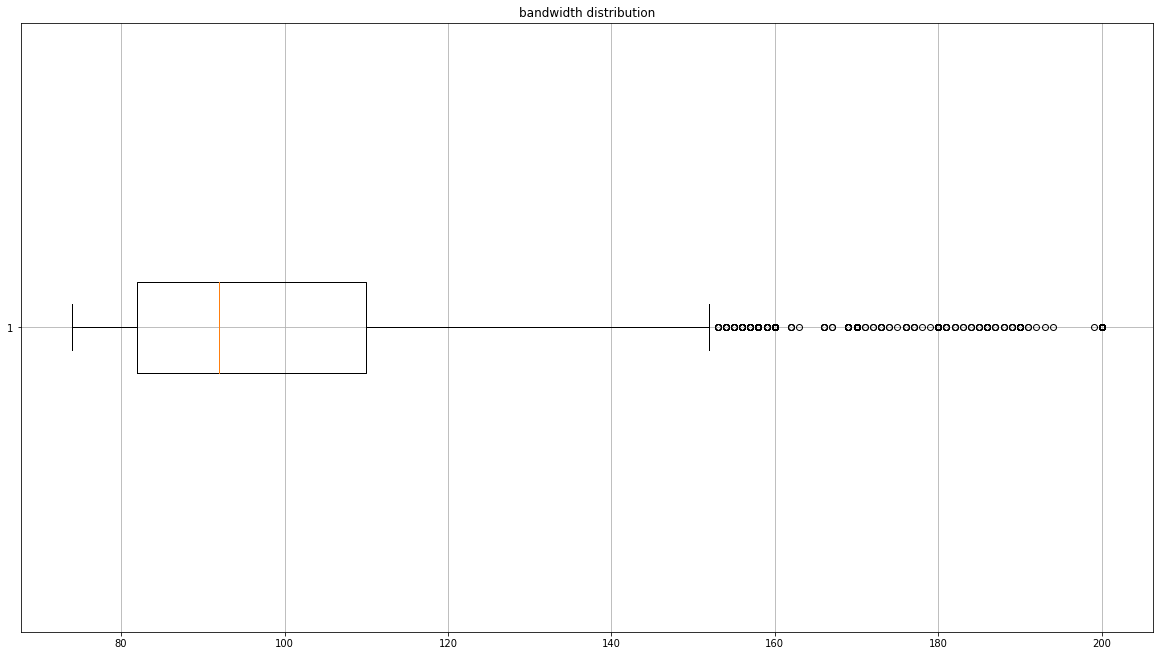

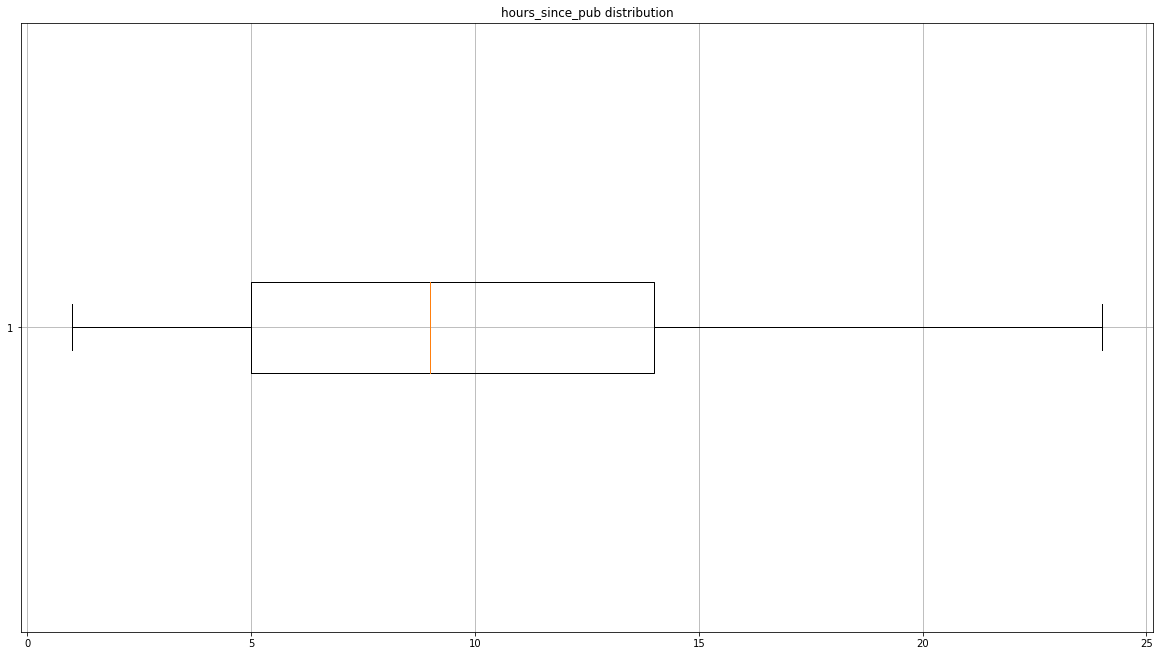

In [16]:
for var in num_vars:
    utils.boxplot(df=df, x=var, title=f'{var} distribution', path=f'../tmp/boxplot_{var}.png')

In [8]:
kwargs = {
    'by': ['consensus_time'],
    'agg': {'med_bd': ('bandwidth', np.median)}
}
agg_df = utils.aggregate(df, **kwargs)

In [9]:
agg_df.head()

,consensus_time,med_bd
0,2021-12-06 00:00:00,92.0
1,2021-12-06 01:00:00,92.5
2,2021-12-06 02:00:00,92.0
3,2021-12-06 03:00:00,92.0
4,2021-12-06 04:00:00,92.5


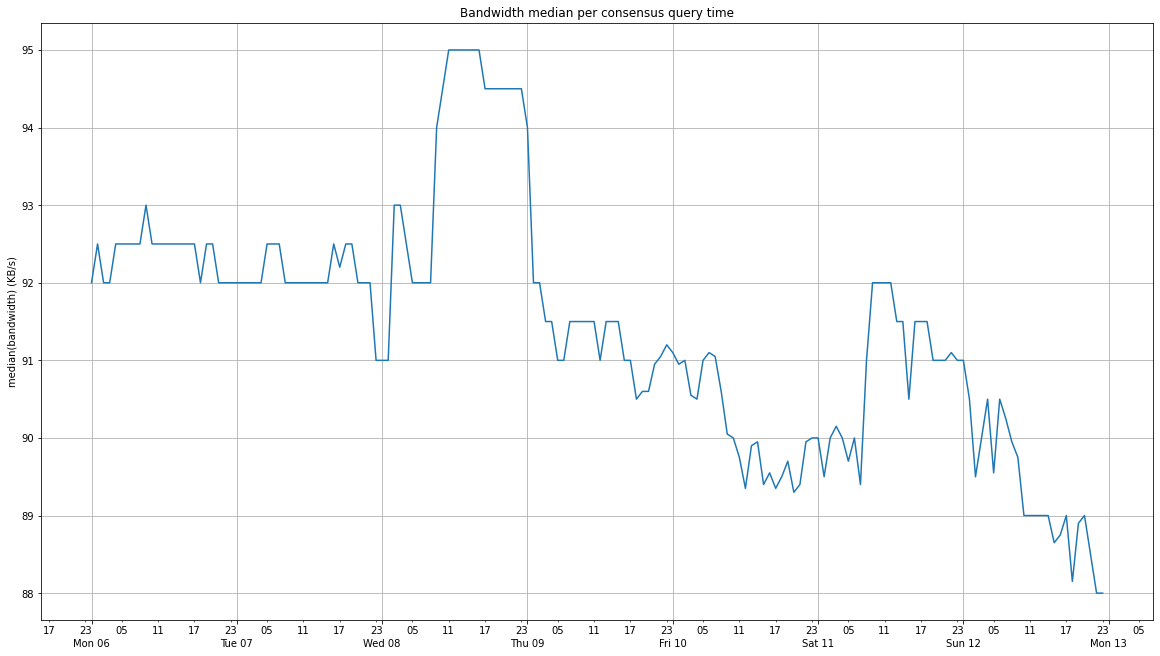

In [10]:
utils.plot(
    df=agg_df,
    x='consensus_time',
    y='med_bd',
    is_timeseries=True,
    title='Bandwidth median per consensus query time',
    xlabel='Consensus time',
    ylabel='median(bandwidth) (KB/s)',
    path='../tmp/median_bandwidth.png'
)

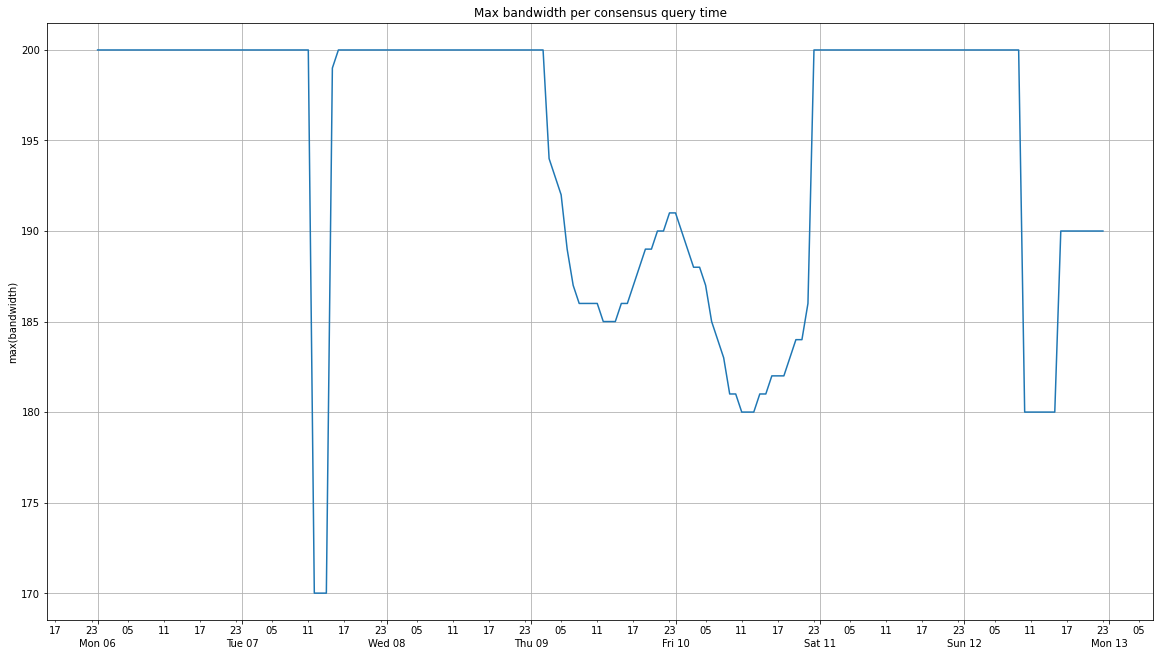

In [11]:
kwargs = {
    'by': ['consensus_time'],
    'agg': {'max_bd': ('bandwidth', np.max)}
}
agg_df = utils.aggregate(df, **kwargs)

utils.plot(
    df=agg_df,
    x='consensus_time',
    y='max_bd',
    is_timeseries=True,
    title='Max bandwidth per consensus query time',
    xlabel='Consensus time',
    ylabel='max(bandwidth)',
    path='../tmp/max_bandwidth.png'
)

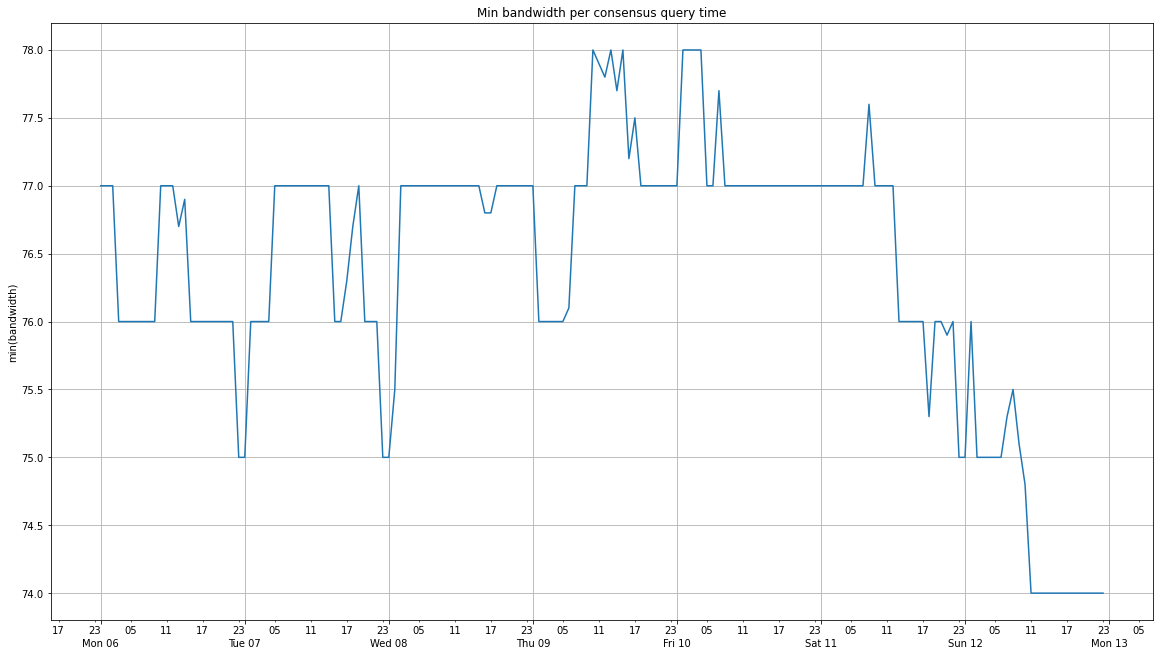

In [12]:
kwargs = {
    'by': ['consensus_time'],
    'agg': {'min_bd': ('bandwidth', np.min)}
}
agg_df = utils.aggregate(df, **kwargs)

utils.plot(
    df=agg_df,
    x='consensus_time',
    y='min_bd',
    is_timeseries=True,
    title='Min bandwidth per consensus query time',
    xlabel='Consensus time',
    ylabel='min(bandwidth)',
    path='../tmp/min_bandwidth.png'
)

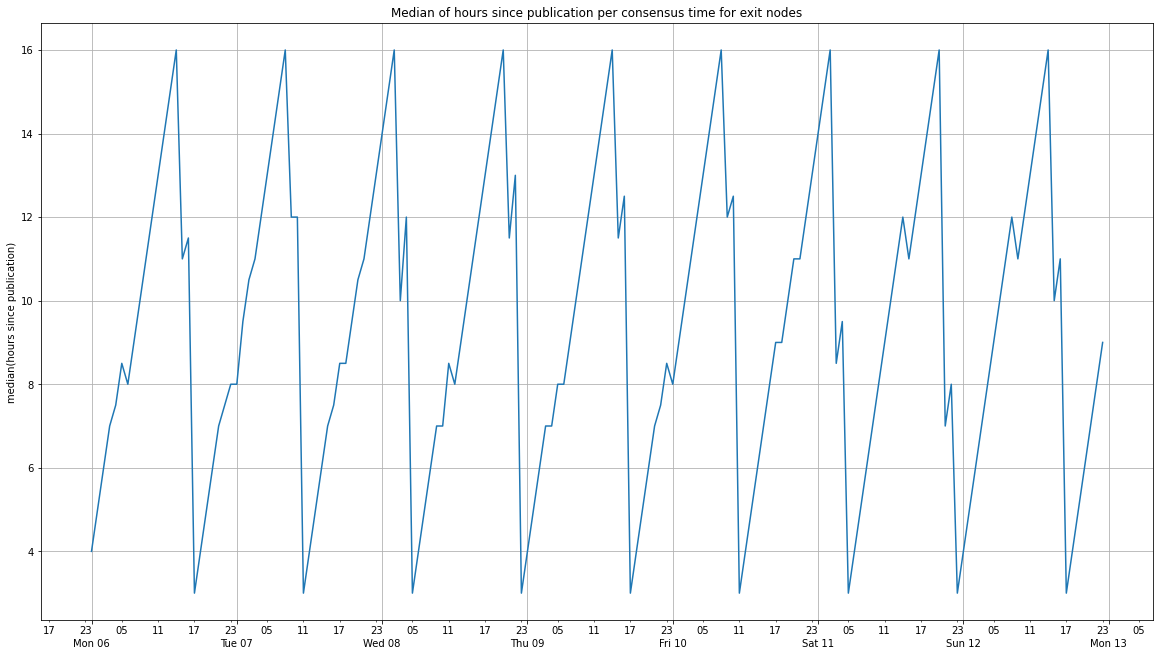

In [13]:
kwargs = {
    'by': ['consensus_time'],
    'agg': {'med_h': ('hours_since_pub', np.median)}
}
agg_df = utils.aggregate(df[df.is_exit == True], **kwargs)

utils.plot(
    df=agg_df,
    x='consensus_time',
    y='med_h',
    is_timeseries=True,
    title='Median of hours since publication per consensus time for exit nodes',
    xlabel='Consensus time',
    ylabel='median(hours since publication)',
    path='../tmp/median_hours_since_pub_for_exit_nodes.png'
)